# OpenFOAM PMDI validation - extinction

This program plots the optical extinction measurment against OpenFOAM density and mixing.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 22/11/2022
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [251]:
# Load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import glob, os
import scipy.io, scipy.spatial, scipy.interpolate, scipy.ndimage
%matplotlib notebook

## Read MATLAB data

Hard-coded for 134a 15% Ethanol

In [355]:
# Load MATLAB data

ExtinctMean=[]
spatialRes=[]
ExtinctXY=[]
ExtinctDescriptors=['NearField','MidField','FarField']

for d in ExtinctDescriptors:

    directory = '/Users/dduke/Desktop/PMDI-papers-data/ResultPack_DDL/Extinction Profile Summary/%s/Placebo/' % d
    try:
        matfilename = glob.glob(directory+'*134E15*/*.mat')
        print(matfilename[0])
        matfile = scipy.io.loadmat(matfilename[0])
        try:
            objname='ExtinctMean'
            ExtinctMean.append( matfile[objname] )
        except KeyError:
            objname='Extinct_case'
            ExtinctMean.append( matfile[objname] )
        spatialRes.append(0.030916) #mm/pix
        mx,my=np.meshgrid(np.arange(matfile[objname].shape[1])*spatialRes[-1],\
                      np.arange(matfile[objname].shape[0])*spatialRes[-1])
        ExtinctXY.append([mx,my])
    except IOError as e:
        print(e)   
    
# Apply origin offset corrections manually
ExtinctXY[0][0] -= 11.18; ExtinctXY[0][1] -= 3.29
ExtinctXY[1][0] -= 25.62; ExtinctXY[1][1] -= 5.5
ExtinctXY[2][0] -= 30.63; ExtinctXY[2][1] -= 16.7

/Users/dduke/Desktop/PMDI-papers-data/ResultPack_DDL/Extinction Profile Summary/NearField/Placebo/ExtinctionCaseProcessedReport_134E15/ExtinctionCaseProcessed.mat
/Users/dduke/Desktop/PMDI-papers-data/ResultPack_DDL/Extinction Profile Summary/MidField/Placebo/ExtinctionCaseProcessedReport134E15/ExtinctionCaseProcessed.mat
/Users/dduke/Desktop/PMDI-papers-data/ResultPack_DDL/Extinction Profile Summary/FarField/Placebo/ExtinctionCaseProcessed_Report134E15/ExtinctionCaseProcessed.mat


<IPython.core.display.Javascript object>


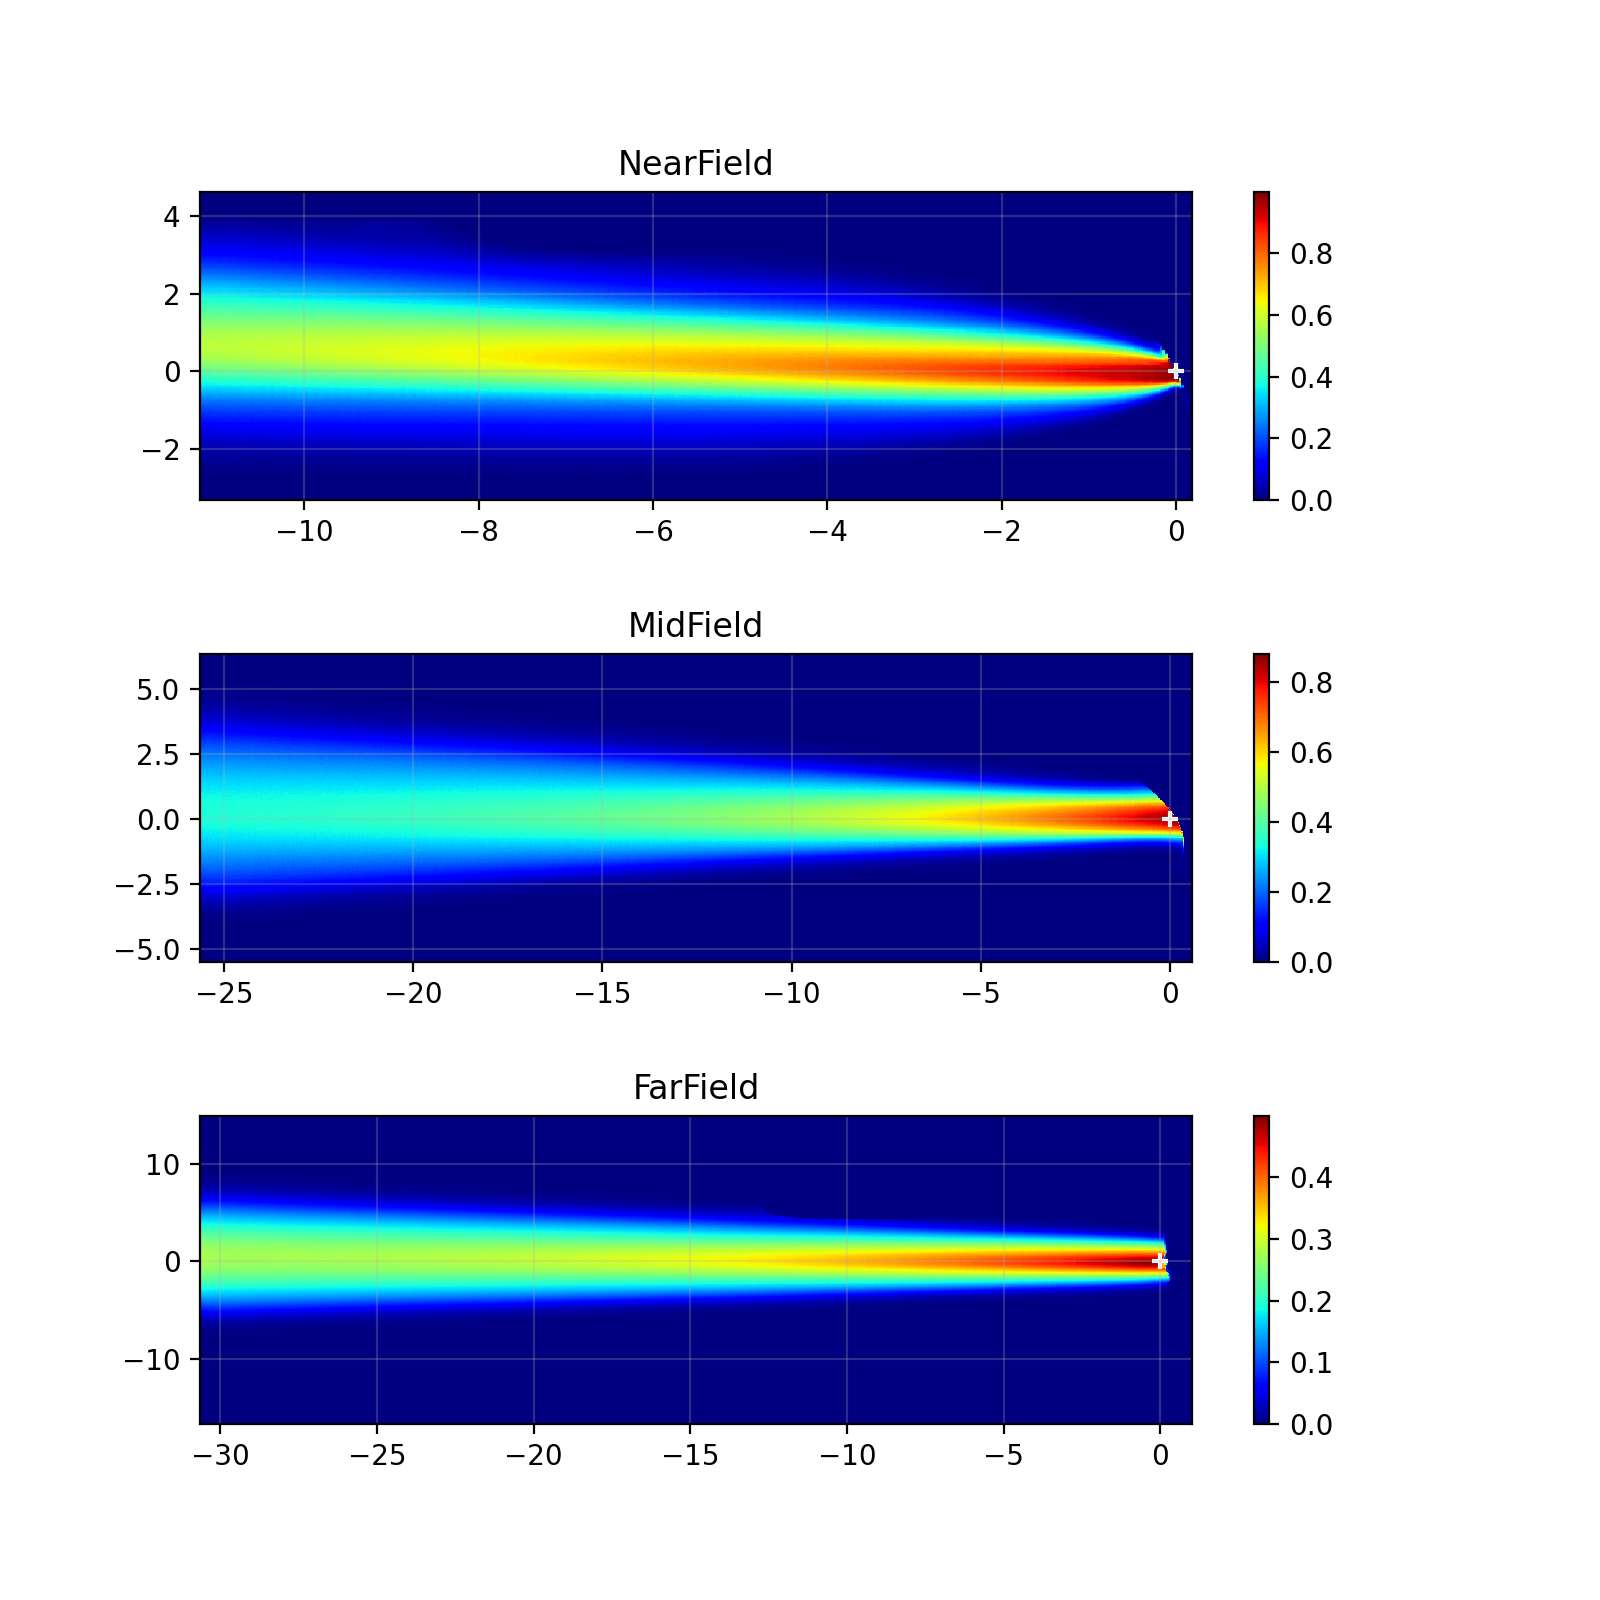

In [356]:
fig=plt.figure(figsize=(8,8))
for i in range(len(ExtinctMean)):
    ax=fig.add_subplot(311+i)
    pcm=plt.pcolormesh(ExtinctXY[i][0],ExtinctXY[i][1],ExtinctMean[i],cmap='jet')
    plt.grid(alpha=.25)
    plt.colorbar(pcm)
    plt.title(ExtinctDescriptors[i])
    ax.scatter((0,),(0,),marker="+",c='w')
plt.subplots_adjust(hspace=.5)

## Read OpenFOAM slice data

Hard-coded for 134a 15% Ethanol
Slice is at X=0, using point interpolated data from Paraview 5.9.1

In [384]:
# Load OF data
directory = '/Users/dduke/Desktop/PMDI-papers-data/Validation/slice/ures/'
ofdata = np.genfromtxt(directory+'sliceX0_134a15pcEtOH.csv',delimiter=',',names=True)

In [358]:
print('Variables:',ofdata.dtype.names)
print('')
print('Points0 range:',ofdata['Points0'].min()-ofdata['Points0'].max())
print('Points1 range:',ofdata['Points1'].min()-ofdata['Points1'].max())
print('Points2 range:',ofdata['Points2'].min()-ofdata['Points2'].max())

Variables: ('OmegaP', 'Points0', 'Points1', 'Points2', 'Sigma', 'T', 'TMean', 'TPrime2Mean', 'U0', 'U1', 'U2', 'UMean0', 'UMean1', 'UMean2', 'UPrime2Mean0', 'UPrime2Mean1', 'UPrime2Mean2', 'UPrime2Mean3', 'UPrime2Mean4', 'UPrime2Mean5', 'V', 'alphaFrac', 'alphaFracMean', 'alphaFracPrime2Mean', 'd32', 'd32Mean', 'd32Prime2Mean', 'h', 'k', 'kMean', 'kPrime2Mean', 'muSgs', 'nD', 'nDMean', 'nDPrime2Mean', 'p', 'pMean', 'pPrime2Mean', 'psi2phase', 'psi2phaseMean', 'psi2phasePrime2Mean', 'rho', 'rhoMean', 'rhoPrime2Mean', 'x', 'xMean', 'xPrime2Mean', 'y', 'yMean', 'yPrime2Mean')

Points0 range: 0.0
Points1 range: -0.07171613538
Points2 range: -0.0417625391


<IPython.core.display.Javascript object>


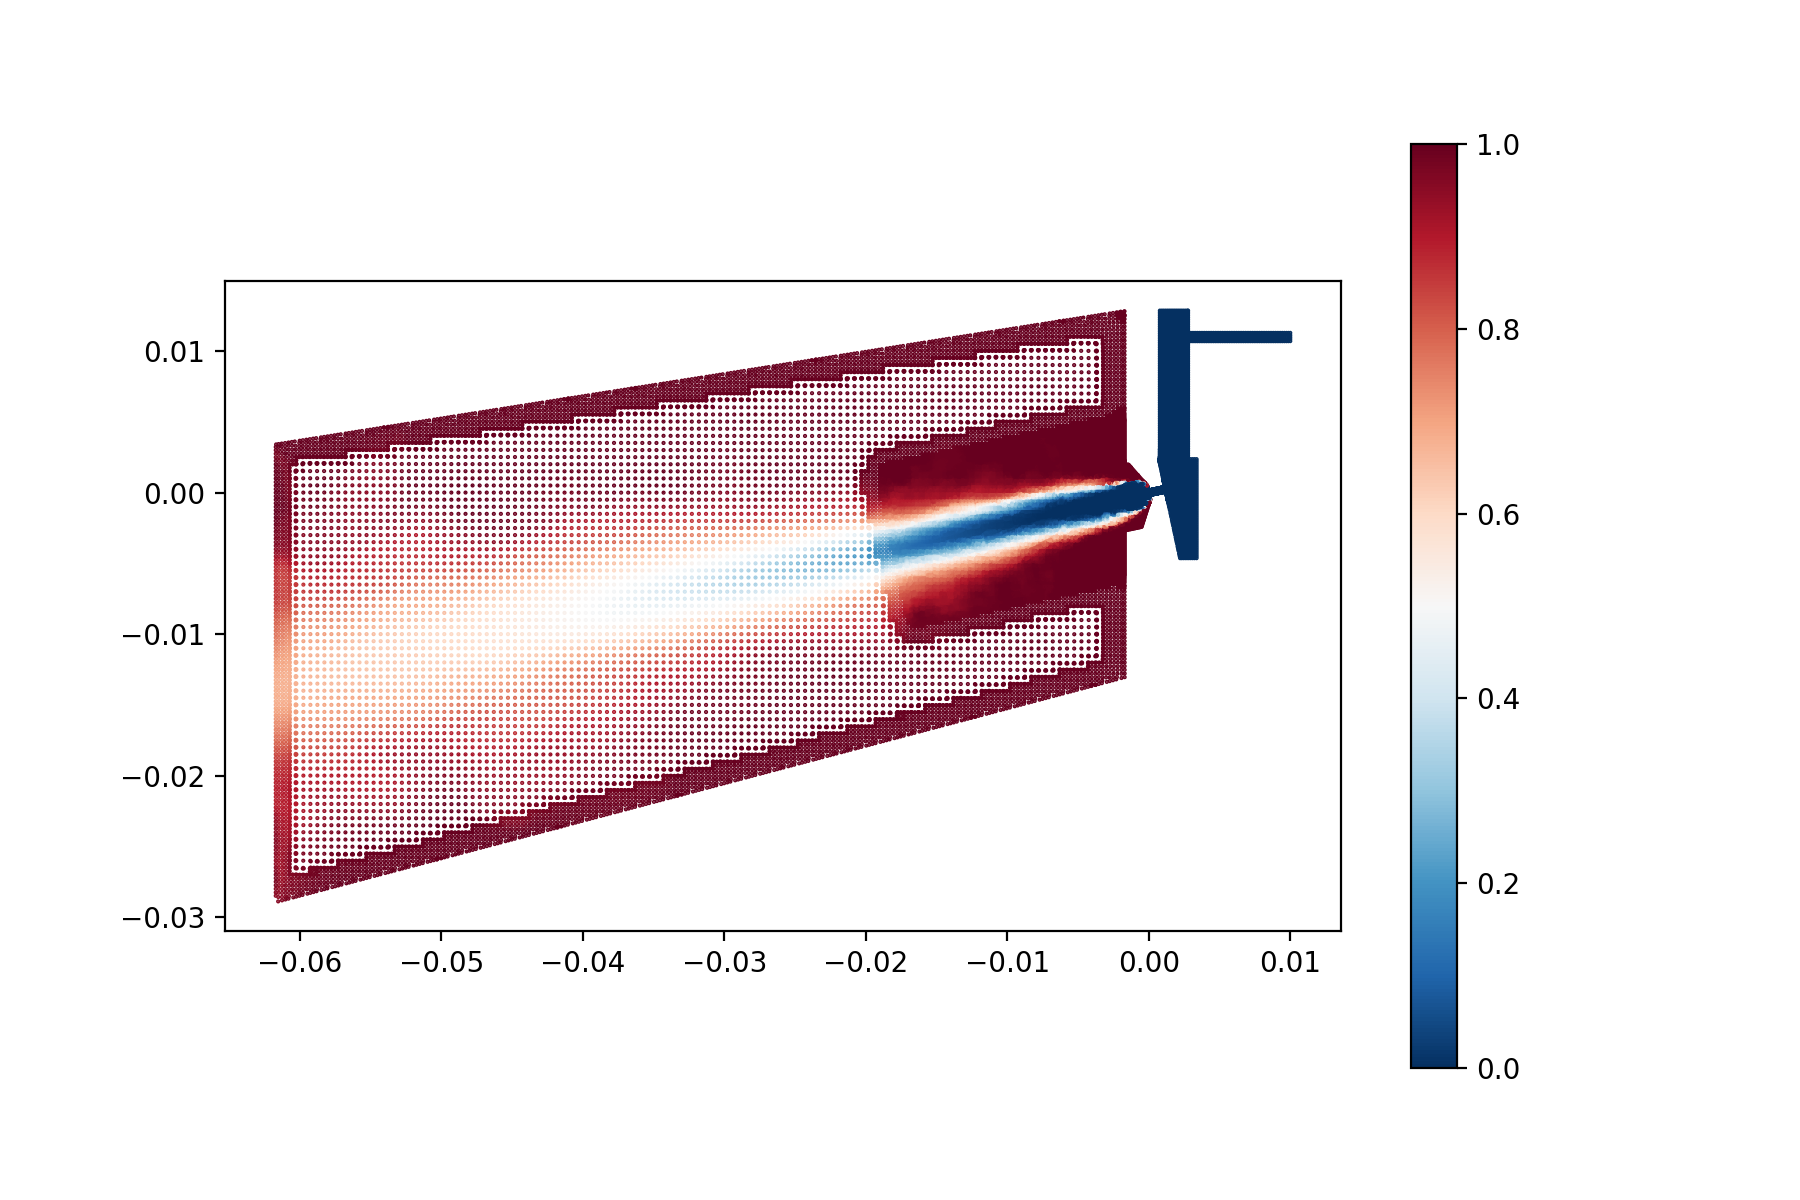

In [387]:
fig=plt.figure(figsize=(9,6))
ax=fig.add_subplot(111)
ax.set_aspect('equal')
s=ax.scatter(ofdata['Points1'], ofdata['Points2'],marker='.',s=1,c=ofdata['yMean'], cmap="RdBu_r")
plt.colorbar(s);

## Interpolate OF data onto rectangular grid for plotting

In [390]:
# Interpolate

# Create output regular grid
xp = np.linspace( ofdata['Points1'].min(), ofdata['Points1'].max(), 4096 )
yp = np.linspace( ofdata['Points2'].min(), ofdata['Points2'].max(), 2048 )
Xp, Yp = np.meshgrid(xp, yp)

In [391]:
# Delaunay triangulation
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html
points = scipy.spatial.Delaunay(np.transpose(np.vstack((ofdata['Points1'], ofdata['Points2']))),\
                                furthest_site=False, incremental=False, qhull_options=None)

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LinearNDInterpolator.html            
fInt = scipy.interpolate.LinearNDInterpolator(points, 1.-ofdata['yMean'], fill_value=np.nan, rescale=False)

           
#triang = tri.Triangulation(ofdata['Points1'], ofdata['Points2'])
#interpolator = tri.LinearTriInterpolator(triang, ofdata['y'])

interpolated = fInt(Xp,Yp)

## Generate plots, adding the extinction data on top in steps.

In [432]:
# rotate and centre the OF data to align
theta=10.
x0,y0 = 1.,-5.335
rotated = scipy.ndimage.rotate(np.nan_to_num(interpolated),theta,reshape=False,cval=0)
#rotated[rotated>=0.999]=0

<IPython.core.display.Javascript object>


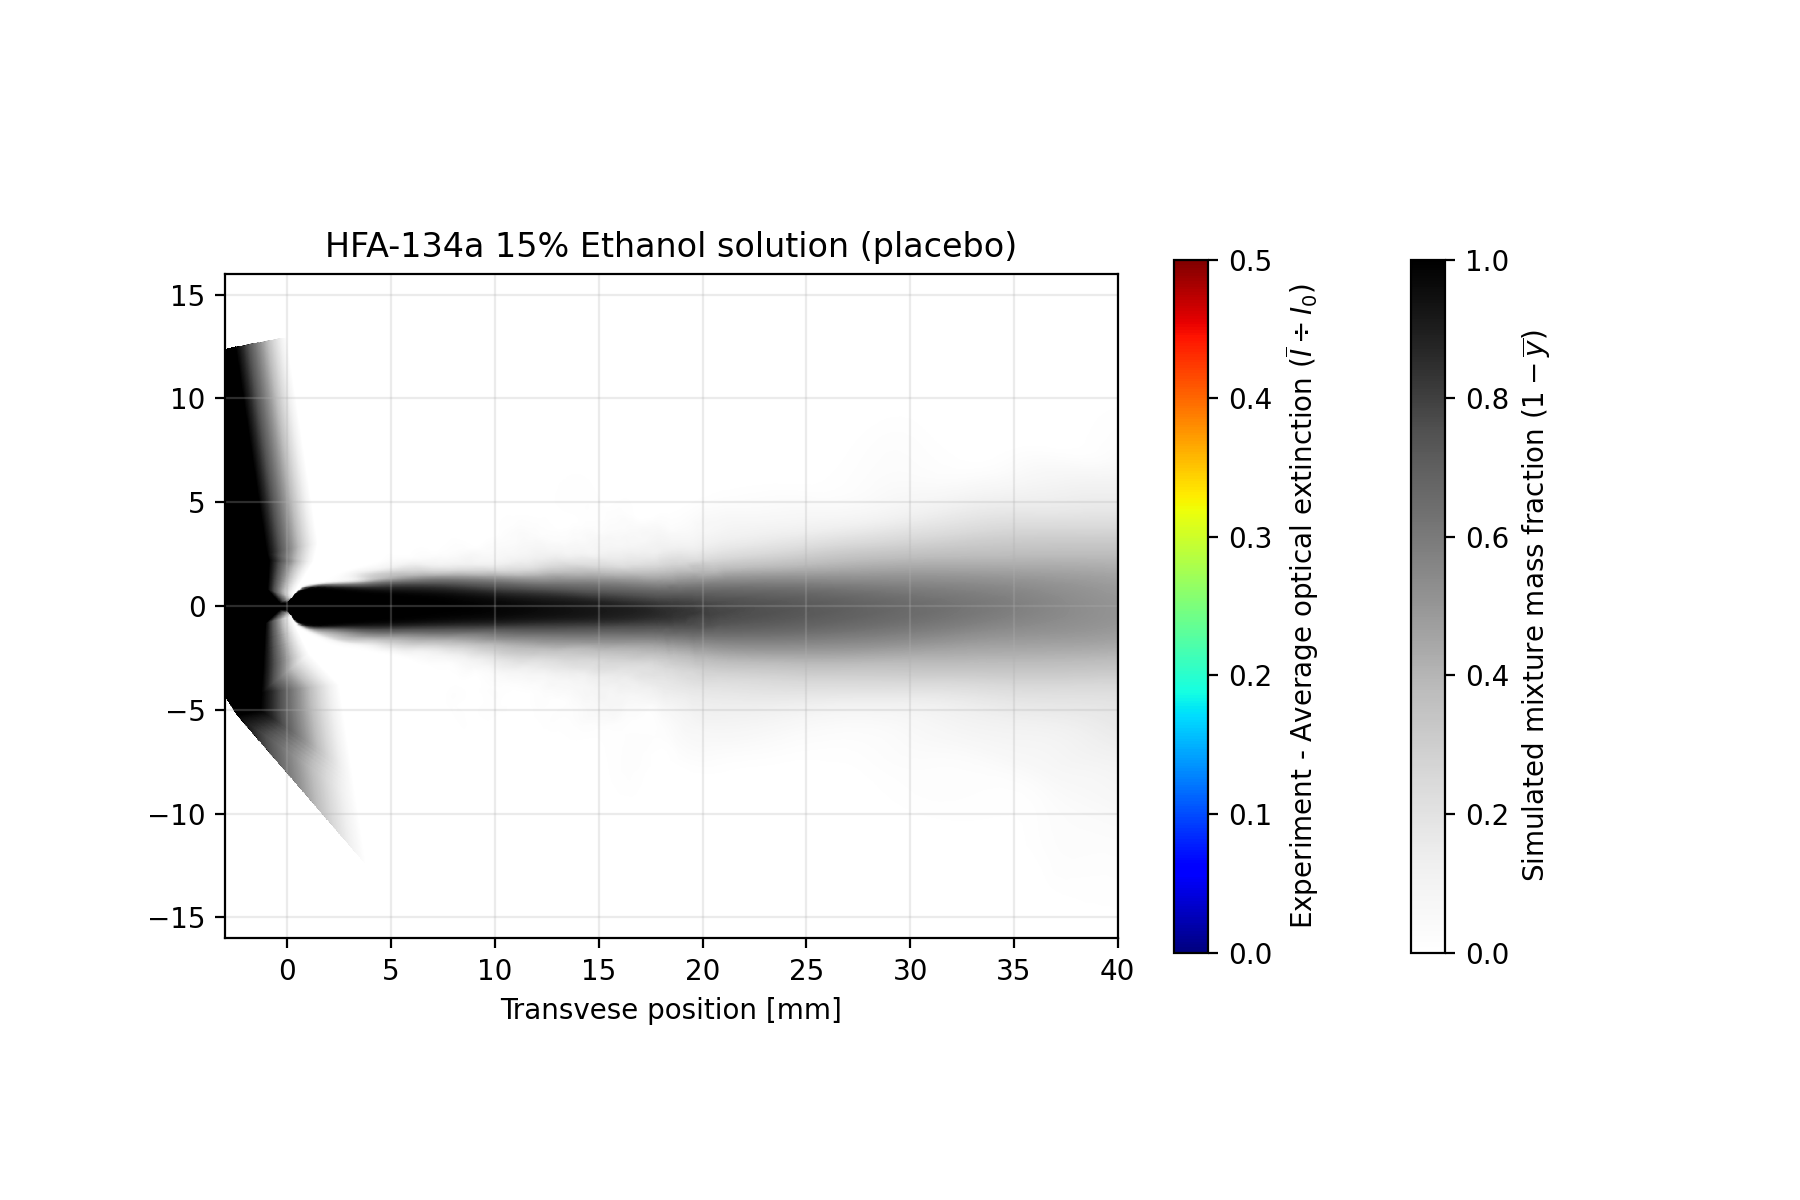

<IPython.core.display.Javascript object>


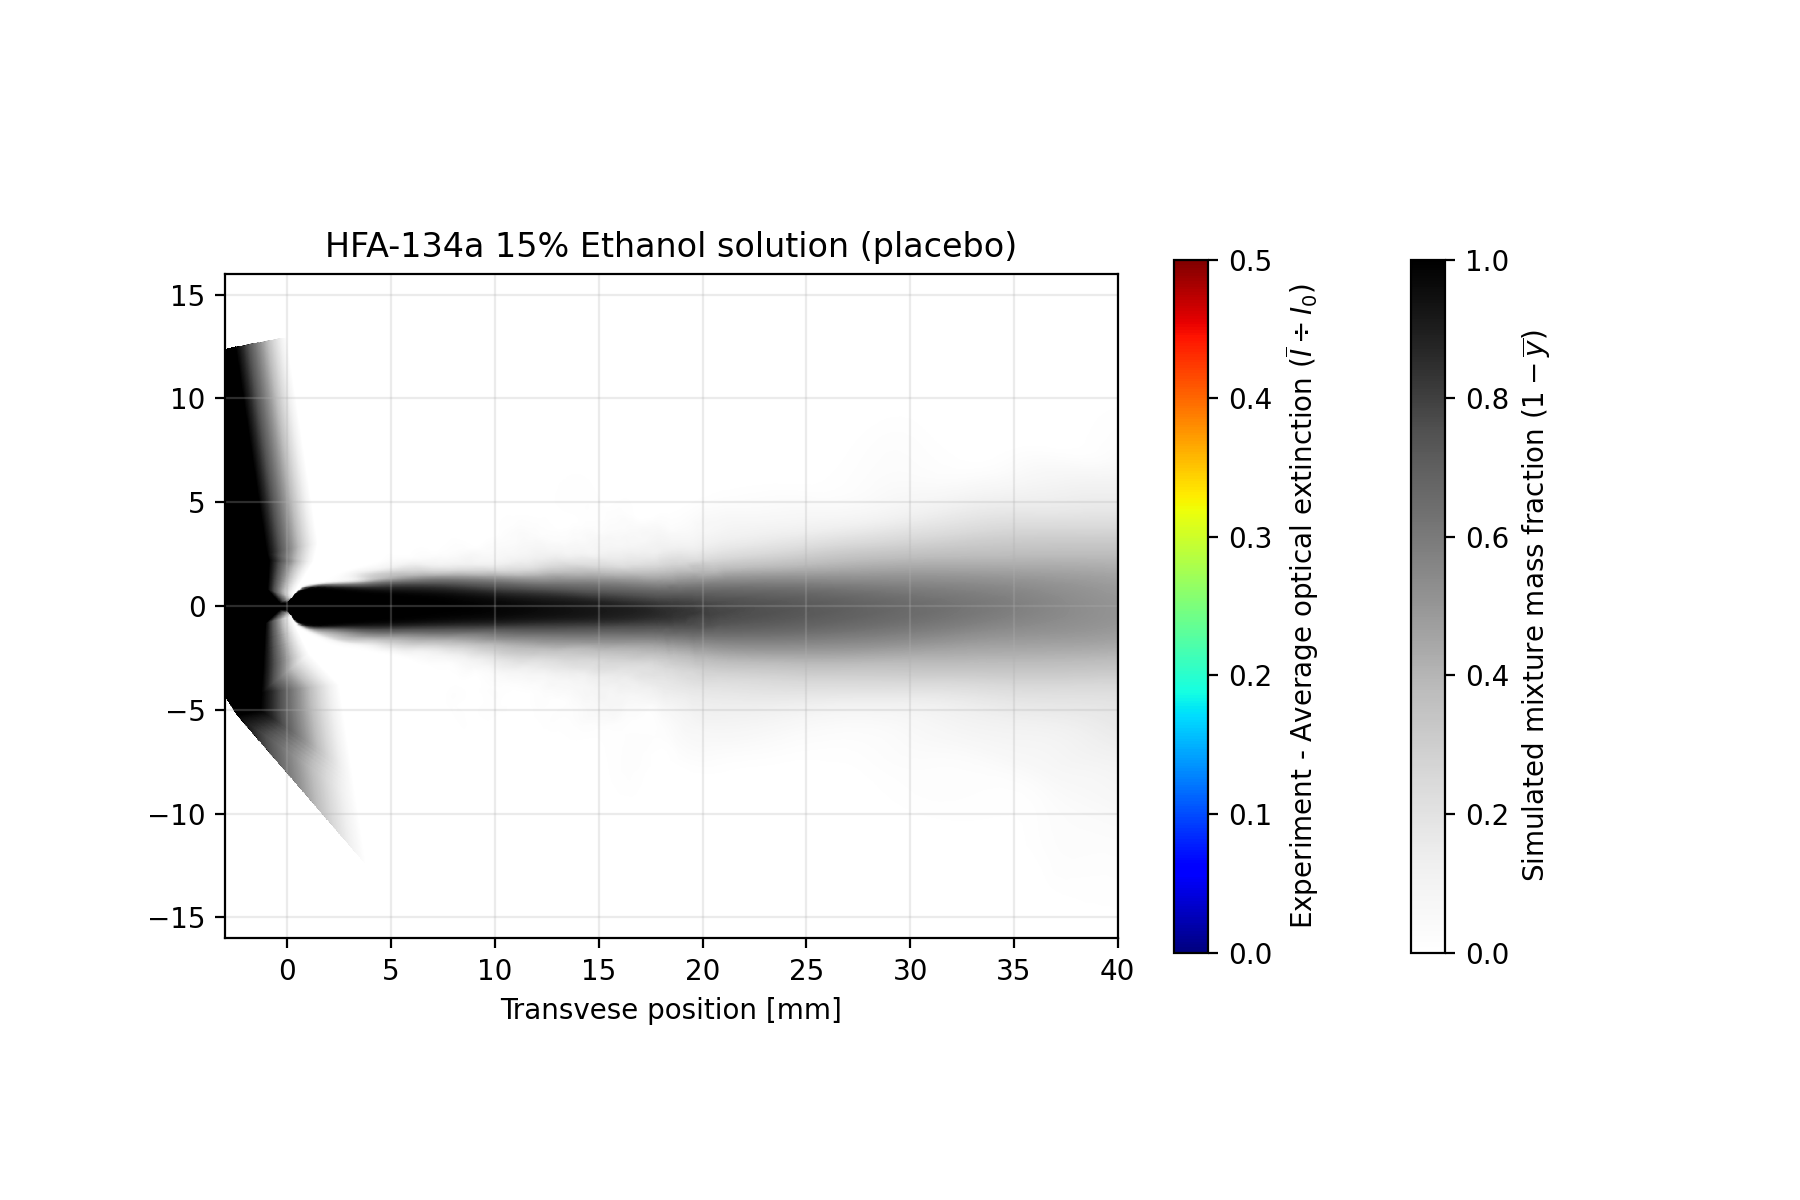

<IPython.core.display.Javascript object>


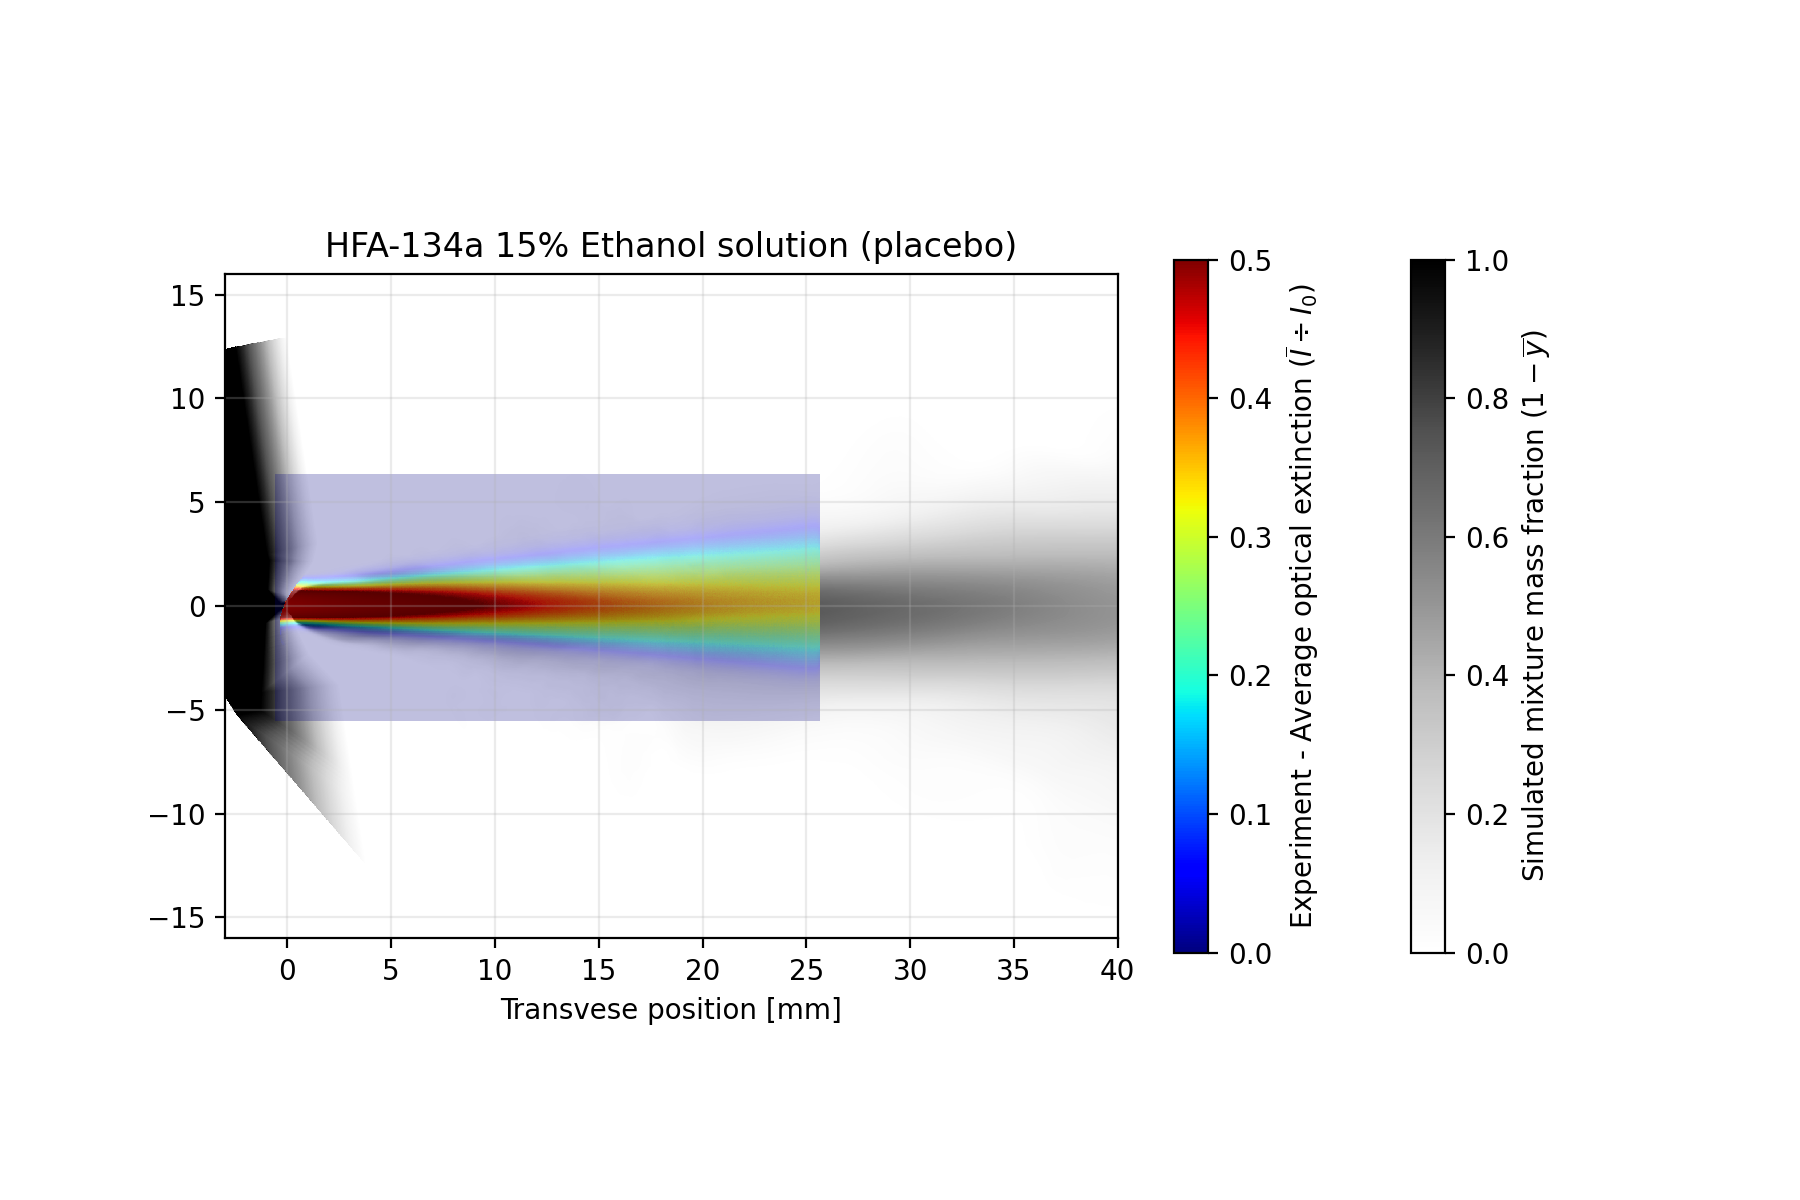

<IPython.core.display.Javascript object>


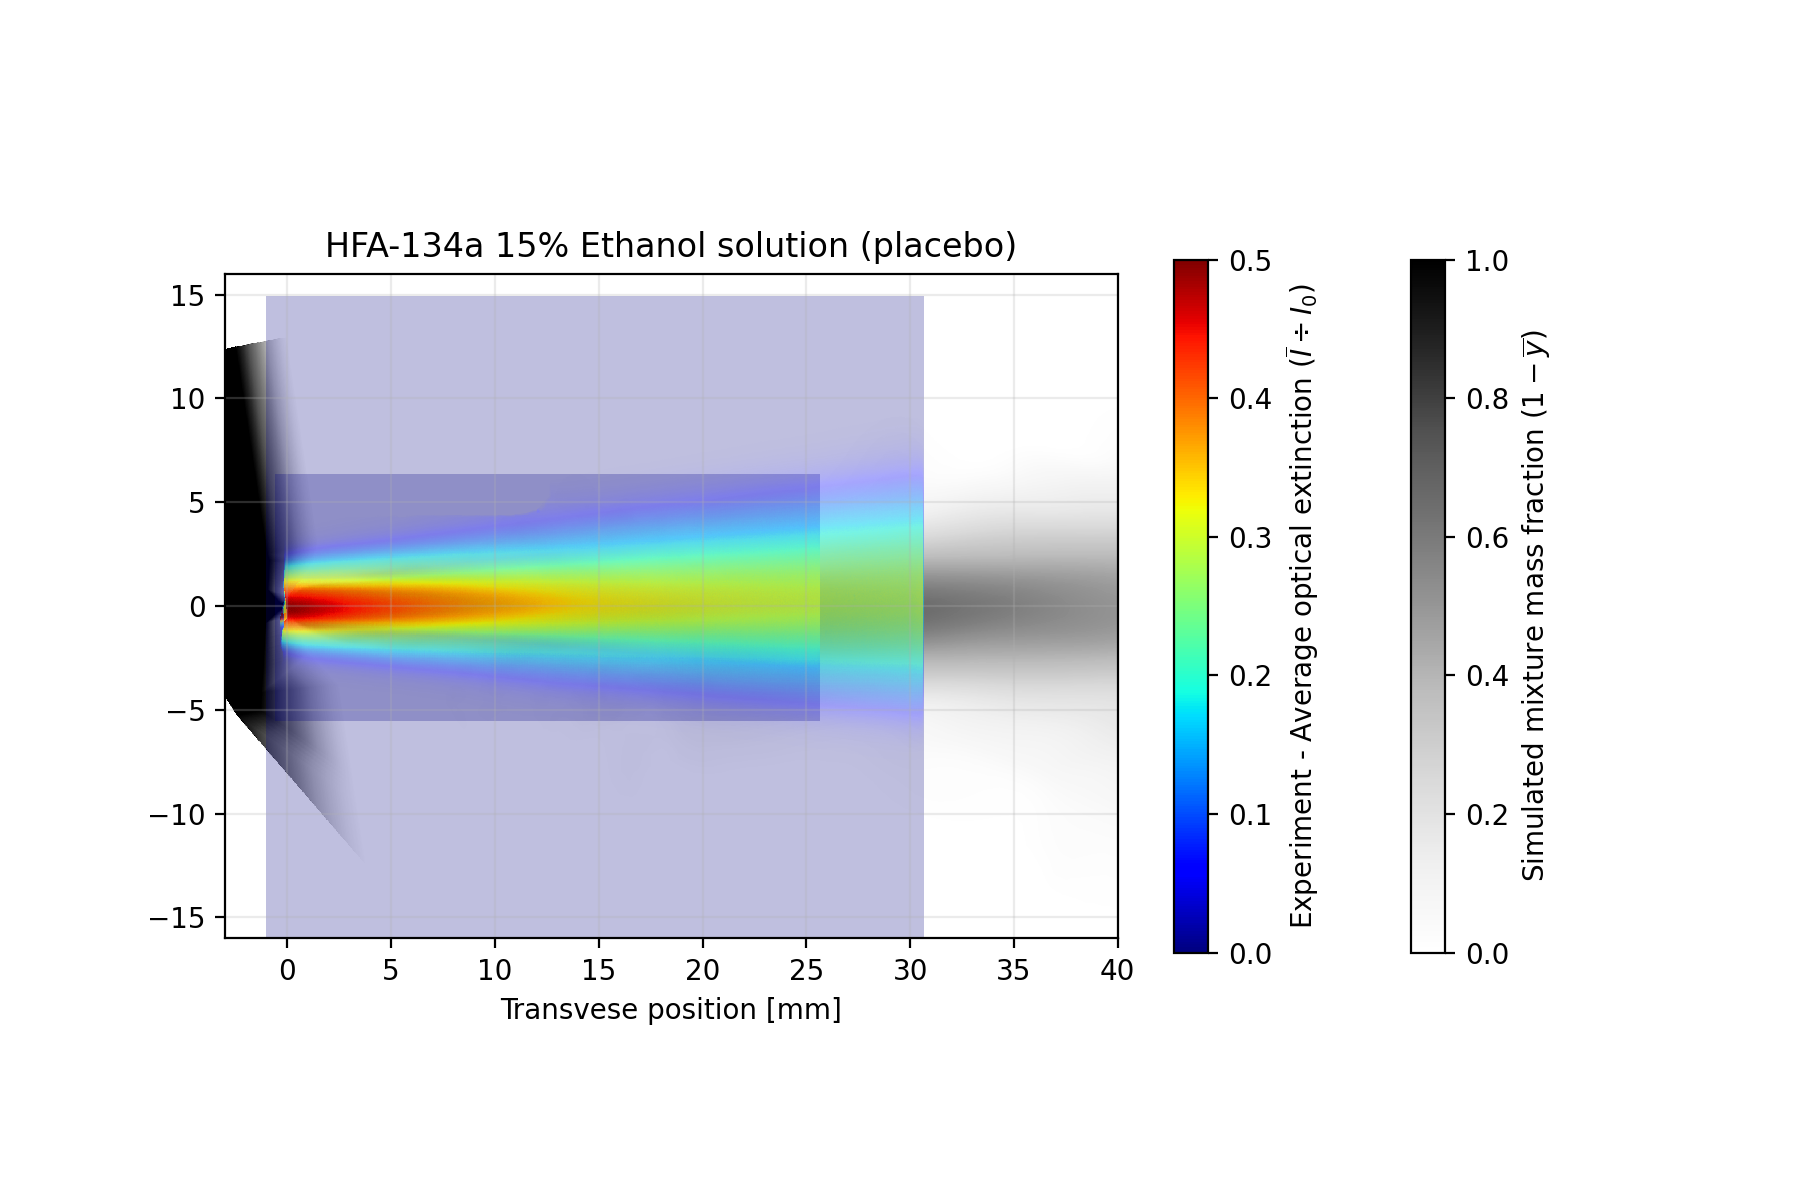

In [438]:
alphaFun = lambda x: 0.25 + 0.75*x/np.nanmax(x)

for ii in range(len(ExtinctMean)+1):

    # Make figure
    fig=plt.figure(figsize=(9,6))
    ax=fig.add_subplot(111)
    ax.set_aspect('equal')

    # Plot the interpolated, rotated OF data
    cntr1=ax.pcolormesh(-(Xp*1e3 - x0), Yp*1e3 - y0, rotated, cmap="Greys", alpha=1, shading='nearest',vmin=0,vmax=1)

    #ax.scatter((0,),(0,),marker='x',c='y') # mark origin

    # Plot the experimental data.
    cmaps=['jet']*3
    for i in np.arange(1,ii): # I SKIP THE NEAR FIELD
        cntr2=ax.pcolormesh(-ExtinctXY[i][0],ExtinctXY[i][1],ExtinctMean[i],\
                 alpha=alphaFun(ExtinctMean[i]),cmap=cmaps[i],vmin=0,vmax=.5)

    plt.xlim(-3,40)
    plt.ylim(-16,16)
    plt.grid(alpha=.25)
    plt.xlabel("Streamwise position [mm]")
    plt.xlabel("Transvese position [mm]")
    plt.title("HFA-134a 15% Ethanol solution (placebo)")

    cb1=fig.colorbar(cntr1, ax=ax,shrink=.75)
    cb1.set_label("Simulated mixture mass fraction ($1-\overline{y}$)")

    cb2=fig.colorbar(cntr2, ax=ax,shrink=.75)
    cb2.set_label("Experiment - Average optical extinction ($\overline{I} \div I_0$)")

    plt.savefig("optical_comparison_135a15pc_%i.png" % ii)